In [8]:
import velocity_metrics.lagrangian.drifters as drifters
import velocity_metrics.lagrangian.cumulative_distance as sde
import velocity_metrics.utils.constant as const  
import os
import warnings
import sys
import datetime
warnings.filterwarnings("ignore")
#sys.path.append('/Odyssey/private/t22picar/2024_DC_WOC-ESA/')
import json

import netCDF4
import numpy
import matplotlib
# import cartopy
import glob
import os
import sys
import datetime
from matplotlib import pyplot
import pickle
import gzip
from tqdm import tqdm
from typing import Optional, Tuple
import logging
logger = logging.getLogger(__name__)
import matplotlib.pyplot
import cartopy.crs as ccrs

In [9]:
base_output="../"
metric_type = "metric"

depth=15
depth_formatted = "{:02}".format(depth)
input_dict = f'{base_output}metric/dictionary/'
input_drifter = '/Odyssey/private/t22picar/2024_DC_WOC-ESA/dc_data/drifter/'
input_lagrangian_position = '/Odyssey/private/t22picar/2024_DC_WOC-ESA/dc_data/lagrangian_position_pickle/'
region="T1"
path_drifter_position = input_lagrangian_position + f'Fictive_pos_Drifters_AOML_region_{region}_{depth_formatted}m_20190101T000000Z_20200101T000000Z.json' 
path_drifter_param = input_dict + 'drifters_parameters.ini'
#path_artificial_drifters = os.path.join("/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_drifters_aoml_15m_10y_11d_bathy_no_sst_mae/metric/Agulhas/", 'unet_uv_drifters_aoml_15m_10y_11d_bathy_no_sst_mae_region_Agulhas_dep1.pyo.gz')
drifter_list = [input_drifter + f'Drifters_AOML_region_{region}_{depth_formatted}m_20190101T000000Z_20200101T000000Z.pyo.gz']

xp_name="unet_uv_drifters_aoml_00m_10y_11d_bathy_mae_neurost"
xp_name_2="GC_00m_4th_h"
if region=="T1":
    region="Agulhas"

fictive_traj = path_drifter_position
#fictive_traj = f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name}/{metric_type}/{region}/{xp_name}_region_{region}_dep0.pyo.gz"
fictive_traj_2=f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name_2}/{metric_type}/Agulhas/{xp_name_2}_region_{region}_dep0.pyo.gz"

In [15]:
ls /Odyssey/private/t22picar/2024_DC_WOC-ESA/dc_data/lagrangian_position_pickle/

Fictive_pos_Drifters_AOML_region_GulfStream_00m_20190101T000000Z_20200101T000000Z.json
Fictive_pos_Drifters_AOML_region_GulfStream_00m_20190101T000000Z_20200101T000000Z.pyo.json
Fictive_pos_Drifters_AOML_region_GulfStream_15m_20190101T000000Z_20200101T000000Z.json
Fictive_pos_Drifters_AOML_region_Mediterranean_00m_20190101T000000Z_20200101T000000Z.json
Fictive_pos_Drifters_AOML_region_Mediterranean_15m_20190101T000000Z_20200101T000000Z.json
Fictive_pos_Drifters_AOML_region_T1_00m_20190101T000000Z_20190201T000000Z.json
Fictive_pos_Drifters_AOML_region_T1_00m_20190101T000000Z_20200101T000000Z.json
Fictive_pos_Drifters_AOML_region_T1_00m_20190101T000000Z_20200101T000000Z.pyo.json
Fictive_pos_Drifters_AOML_region_T1_15m_20190101T000000Z_20200101T000000Z.json
Fictive_pos_Drifters_AOML_region_T1_15m_20190101T000000Z_20200101T000000Z.pyo.json
FileZilla.xml


In [10]:
def dist(lon1: numpy.ndarray, lat1: numpy.ndarray, lon2: numpy.ndarray,
         lat2: numpy.ndarray) -> numpy.ndarray:
    coslat = numpy.cos(numpy.deg2rad(lat1))
    dist = numpy.sqrt(((lon1 - lon2) * coslat)**2 + (lat1 - lat2)**2)
    return dist

def compute_nlcs(lon_d: numpy.ndarray, lat_d: numpy.ndarray,
                 time_d: numpy.ndarray, lon_f: numpy.ndarray,
                 lat_f: numpy.ndarray, time_f: numpy.ndarray) -> numpy.ndarray:
    # Compute Normalized Lagrangian Cumulative Separation
    lon_d_interp = numpy.interp(time_f, time_d, lon_d)
    lat_d_interp = numpy.interp(time_f, time_d, lat_d)
    dde = numpy.zeros(numpy.shape(lon_f))
    sde = numpy.zeros(numpy.shape(lon_f))
    # Distance between points in drifter
    lld = dist(lon_d_interp[1:], lat_d_interp[1:], lon_d_interp[:-1],
               lat_d_interp[:-1])

    len_time, len_pa = numpy.shape(lon_f)
    first_time = 2
    for pa in range(len_pa):
        # separation between drifter and fictive particule
        dde[:, pa] = dist(lon_d_interp[:], lat_d_interp[:], lon_f[:, pa],
                          lat_f[:, pa])
        for it in range(first_time, len_time-1):
            # Normalized cumulative separation
            #sde[it, pa] = sum(dde[2: it, pa]) / sum(lld[1: 
            # Normalized cumulative separation
            dde_sum = 0
            lld_sum = 0
            for i in range(first_time, it+1):
                dde_sum +=  dde[i-1, pa]
                lld_sum += sum(lld[first_time:i])
            #lld_sum += lld[it + i + 1]
            sde[it, pa] = dde_sum / lld_sum if lld_sum != 0 else numpy.nan
#            sde[it, pa] = sum(dde[2: it+1, pa]) / sum(lld[1: it+1])
            #if lld[it] < 5.e-6:
            #    sde[it, pa] = numpy.nan
    return sde, dde, lon_d_interp, lat_d_interp

def read_fictive_traj_netcdf(ifile: str, nstep: Optional[int] = 250):
    data = netCDF4.Dataset(ifile, 'r')
    dic_attr = {'ide': data.ide, 'data_type': data.data_type,
                'label': data.label, 'depth': data.depth}
    lon = data.variables['lon_hr'][:nstep, :]
    # try:
    lat = data.variables['lat_hr'][:nstep, :]
    mask = data.variables['mask_hr'][:nstep, :]
    _mask = ((abs(lon) > 360) | (abs(lat) > 90) | (mask == 1))
    lon[_mask] = numpy.nan
    lat[_mask] = numpy.nan
    time = data.variables['time_hr'][:nstep]
    data.close()
    
    return lon, lat, time, dic_attr

def read_fictive_traj_pickle(data: dict, nstep: Optional[int] = 250):
    dic_attr = {'ide': data['ide'], 'data_type': data['data_type'],
                'label': data['label'], 'depth': data['depth'],
                'first_date': data['first_date']}
    lon = data['lon_hr'][:nstep, :]
    # try:
    lat = data['lat_hr'][:nstep, :]
    mask = data['mask_hr'][:nstep, :]
    _mask = ((abs(lon) > 360) | (abs(lat) > 90) | (mask == 1))
    lon[_mask] = numpy.nan
    lat[_mask] = numpy.nan
    time = data['time_hr'][:nstep]
    return lon, lat, time, dic_attr


def get_fictive_traj(ifile: str, dic_all: dict, drifter_pyo: str, isplot: Optional[bool] = True,
                    projection: Optional[str] = None) -> dict:
    
    if 'gz' in os.path.splitext(drifter_pyo[0])[-1]:
        with gzip.open(drifter_pyo[0], 'rb') as f:
            dic_drif = pickle.load(f)
    else:
        with open(drifter_pyo[0], 'rb') as f:
            dic_drif = pickle.load(f)

    _fname_out = ifile
    res = read_fictive_traj_pickle(dic_all[ifile])
    hrlon, hrlat, hrtime, dic_attr = res
    hrlon = numpy.mod(hrlon + 180, 360) - 180

    if dic_attr['ide'] not in dic_drif:
        print('No ide in dic drif')
        return
    
    logging.debug(f'Read drifter data {drifter_pyo}')
    _lon = numpy.mod(numpy.array(dic_drif[dic_attr['ide']]['lon']) + 180,
                        360) - 180
    _lat = dic_drif[dic_attr['ide']]['lat']
    _time = numpy.array(dic_drif[dic_attr['ide']]['time'])
    first_day = datetime.datetime.timestamp(dic_attr['first_date'])
    # ddays = [(x - first_day).total_seconds() / 86400 for x in _time]
    ddays = [(x - first_day) / 86400 for x in _time]

    if hrtime[-1] > ddays[-1]:
        print("Pb with hrtime" )
        #return 

    sde, dde, _lon_interp, _lat_interp = compute_nlcs(_lon, _lat, ddays,
                                                        hrlon, hrlat, hrtime)
    
    return hrlon, hrlat, hrtime, dic_attr,_lon_interp,_lat_interp


In [11]:
def get_list_advection(date_target,fictive_traj):
    if os.path.isdir(fictive_traj):
        input_netcdf = True
        list_advection = glob.glob(os.path.join(fictive_traj, '*nc'))
    else:
        try:
            if 'gz' in os.path.splitext(fictive_traj)[-1]:
                with gzip.open(fictive_traj, 'rb') as f:
                    dic_all = pickle.load(f)
            else:
                with open(fictive_traj, 'rb') as f:
                    dic_all = pickle.load(f)
        except pickle.UnpicklingError:
            logger.error(f'{fictive_traj} should be a pickle object')
            sys.exit(1)
        input_netcdf = False

        # Filtrer les entrées
        filtered_items = {
            key: value
            for key, value in dic_all.items()
            if value.get('first_date').strftime("%Y-%m-%d")  == date_target
        }
        print()
        list_advection = list(filtered_items.keys())
        nb_drifter = len(list_advection)
        print(f"number of drifter : {nb_drifter}")
        return list_advection,dic_all


In [12]:
import xarray

lon_max=35
lon_min=10
lat_max=-30
lat_min=-43

def get_sst_L4_8th(date_target):
    date_target = datetime.datetime.strptime(date_target, "%Y-%m-%d") + datetime.timedelta(days=5)
    result_filepath = "/Odyssey/private/t22picar/data/sst_L4/SST_L4_OSTIA_2019_8th.nc"
    map = xarray.open_dataset(result_filepath).sel(time=date_target)["thetao"].sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
    return map

def get_sst_L4_8th_log(date_target):
    date_target = datetime.datetime.strptime(date_target, "%Y-%m-%d") + datetime.timedelta(days=5)
    result_filepath = "/Odyssey/private/t22picar/data/sst_L4/SST_L4_OSTIA_2019_8th.nc"
    map = xarray.open_dataset(result_filepath).sel(time=date_target)["thetao"].sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
    du_dx = (numpy.abs(map.differentiate("lon")))
    du_dy = (numpy.abs(map.differentiate("lat")))
    grad = numpy.log(du_dx + du_dy)
    map.values = grad
    return map

def get_sst_L4_4th(date_target):
    date_target = datetime.datetime.strptime(date_target, "%Y-%m-%d") + datetime.timedelta(days=5)
    result_filepath = "/Odyssey/private/t22picar/data/sst_L4/SST_L4_OSTIA_2019_4th.nc"
    map = xarray.open_dataset(result_filepath).sel(time=date_target)["thetao"].sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
    return map

def get_sst_L4_4th_log(date_target):
    date_target = datetime.datetime.strptime(date_target, "%Y-%m-%d") + datetime.timedelta(days=5)
    result_filepath = "/Odyssey/private/t22picar/data/sst_L4/SST_L4_OSTIA_2019_4th.nc"
    map = xarray.open_dataset(result_filepath).sel(time=date_target)["thetao"].sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
    du_dx = (numpy.abs(map.differentiate("lon")))
    du_dy = (numpy.abs(map.differentiate("lat")))
    grad = numpy.log(du_dx + du_dy)
    map.values = grad
    return map

import xarray
def get_sst_L3_8th(date_target):
    date_target = datetime.datetime.strptime(date_target, "%Y-%m-%d") + datetime.timedelta(days=5)
    result_filepath = "/Odyssey/private/t22picar/data/sst_L3/SST_L3_2010-01-01-2020-01-01_8th.nc"
    map = xarray.open_dataset(result_filepath).sel(time=date_target)["thetao"].sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
    return map

import xarray
def get_sst_L3(date_target):
    date_target = datetime.datetime.strptime(date_target, "%Y-%m-%d") + datetime.timedelta(days=5)
    result_filepath = "/Odyssey/private/t22picar/data/sst_L3/SST_L3_2010-01-01-2020-01-01.nc"
    map = xarray.open_dataset(result_filepath).sel(time=date_target)["adjusted_sea_surface_temperature"].sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
    map=map.rename({"longitude": "lon" })
    map=map.rename({"latitude": "lat"})
    return map

def get_sst_MW(date_target):
    date_target = datetime.datetime.strptime(date_target, "%Y-%m-%d") + datetime.timedelta(days=5)
    result_filepath = "/Odyssey/private/t22picar/data/sst_L4/SST_MW_2010_2020_4th.nc"
    map = xarray.open_dataset(result_filepath).sel(time=date_target)["analysed_sst"].sel(lon=slice(10,30)).sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
    return map

In [13]:
date_target = "2019-03-24" 

def plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_neurost):
    alpha=0.2
    map_back = get_sst_L4_8th(date_target)
    list_advection, dic_all = get_list_advection(date_target,fictive_traj)
    list_advection_neurost, dic_all_neurost = get_list_advection(date_target,fictive_traj_neurost)

    figure = pyplot.figure(figsize=(12, 12))
    proj=ccrs.PlateCarree()


    for advection,advection_neurost in zip(list_advection,list_advection_neurost):

        lon_f_n, lat_f_n, hrtime_n, dic_attr_n,lon_d,lat_d = get_fictive_traj(advection_neurost,dic_all_neurost,drifter_list)

        lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)

        proj=ccrs.PlateCarree()
        
        ax0 = pyplot.subplot(111, projection=proj)


        extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                    numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
        
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
        for pa in range(0, numpy.shape(lon_f)[1], 1):
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha,zorder=5)

        for pa in range(0, numpy.shape(lon_f_n)[1], 1):
            ax0.plot(lon_f_n[:, pa], lat_f_n[:, pa], 'g', transform=proj,alpha=alpha,zorder=5)

        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1,zorder=10)
        ax0.scatter(lon_d[0],lat_d[0], transform=proj,alpha=1,c='k',s=20,marker='o',zorder=10)
        ax0.scatter(lon_d[-1],lat_d[-1], transform=proj,alpha=1,c='k',s=20,marker='^',zorder=10)
    
    sst_cm = ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)

    ax0.plot(lon_f[:, 0], lat_f[:, 0], 'b', transform=proj,alpha=1,label=dic_attr["data_type"])
    ax0.plot(lon_f_n[:, 0], lat_f_n[:, 0], 'g', transform=proj,alpha=1,label=dic_attr_n["data_type"])
    ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1,label="Drifter")


    ax0.legend()
    ax0.set_title(f"First date advection : {date_target}")

    cbar = matplotlib.pyplot.colorbar(sst_cm, ax=ax0, orientation='vertical', pad=0.08,shrink=0.35)
    cbar.set_label("SST day+5 (K)")



In [14]:
date_target = "2019-07-24" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2)

/Odyssey/private/t22picar/2024_DC_WOC-ESA/dc_data/lagrangian_position_pickle/Fictive_pos_Drifters_AOML_region_T1_15m_20190101T000000Z_20200101T000000Z.json should be a pickle object


SystemExit: 1


number of drifter : 4

number of drifter : 4


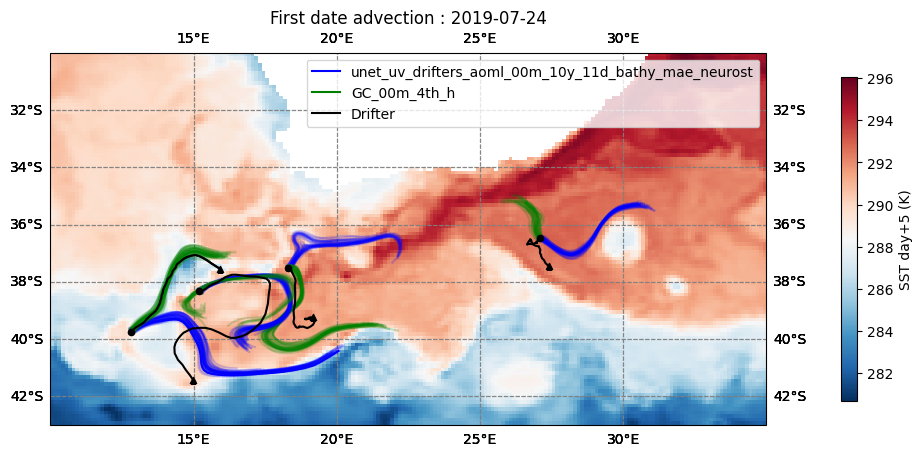

In [32]:
date_target = "2019-07-24" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2)


number of drifter : 7

number of drifter : 7
Pb with hrtime
Pb with hrtime


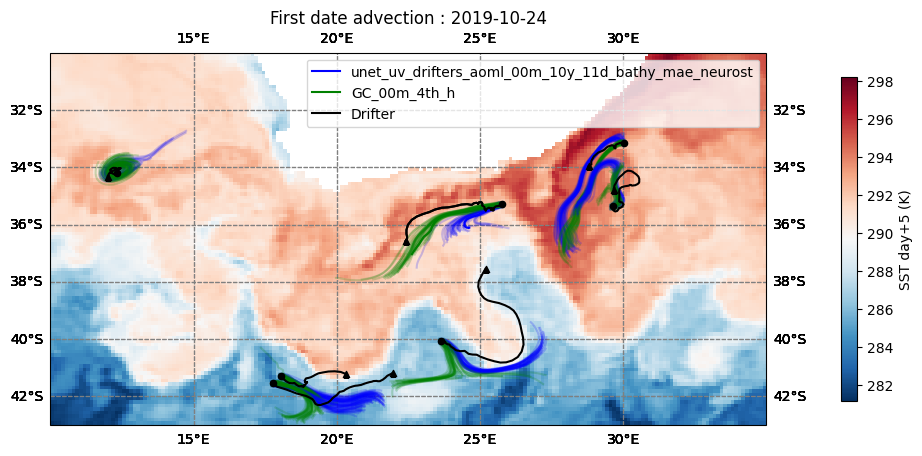

In [33]:
date_target = "2019-10-24" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2)


number of drifter : 4

number of drifter : 4
Pb with hrtime
Pb with hrtime


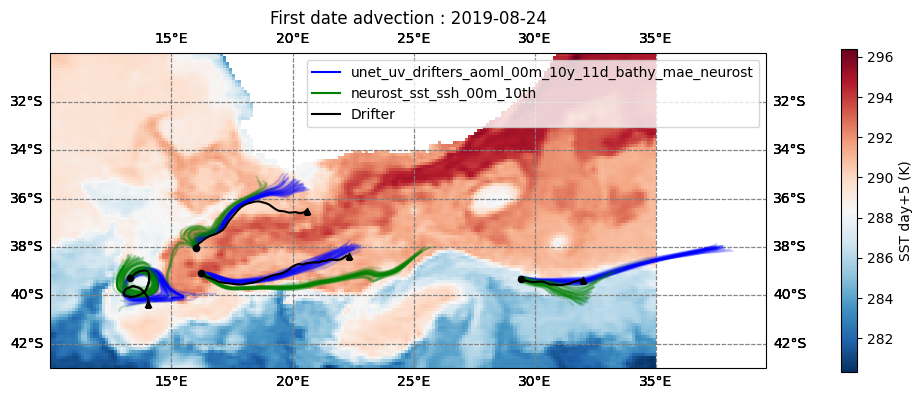

In [23]:
date_target = "2019-08-24" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2)


number of drifter : 5

number of drifter : 5
Pb with hrtime
Pb with hrtime


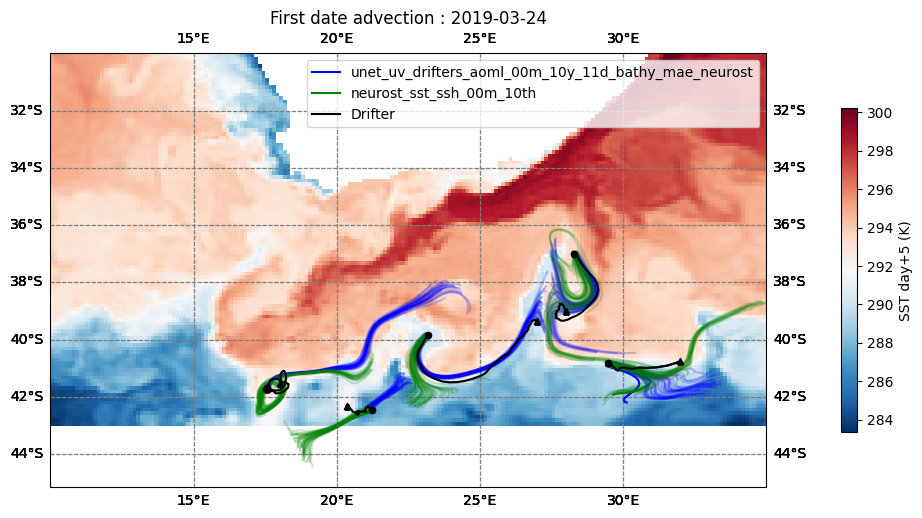

In [16]:
date_target = "2019-03-24" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2)


number of drifter : 7

number of drifter : 7
Pb with hrtime
Pb with hrtime


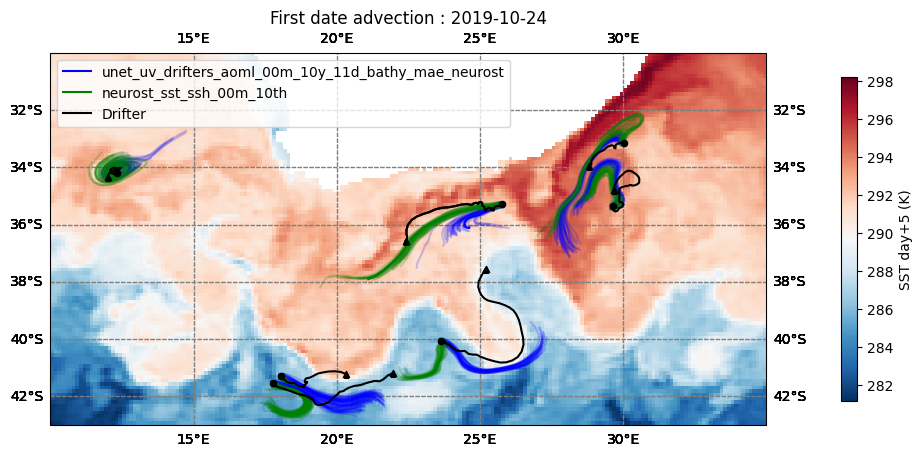

In [17]:
date_target = "2019-10-24" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2)


number of drifter : 5

number of drifter : 5


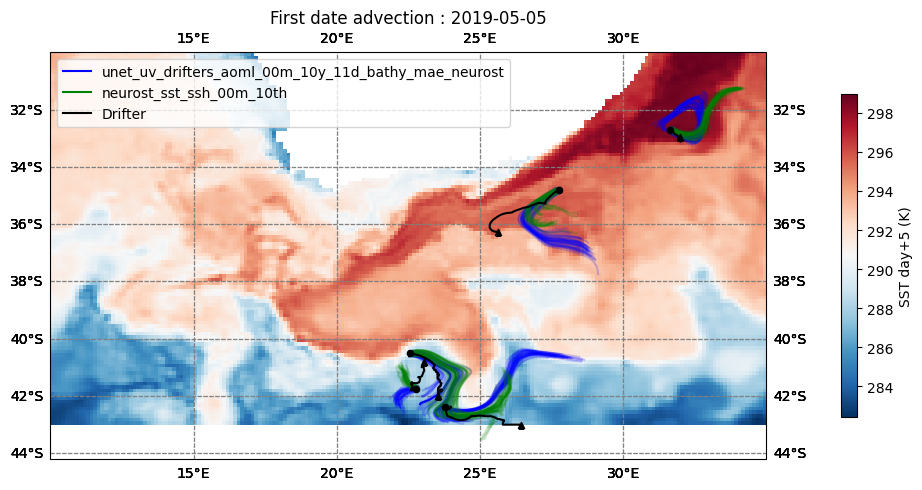

In [18]:
date_target = "2019-05-05" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2)

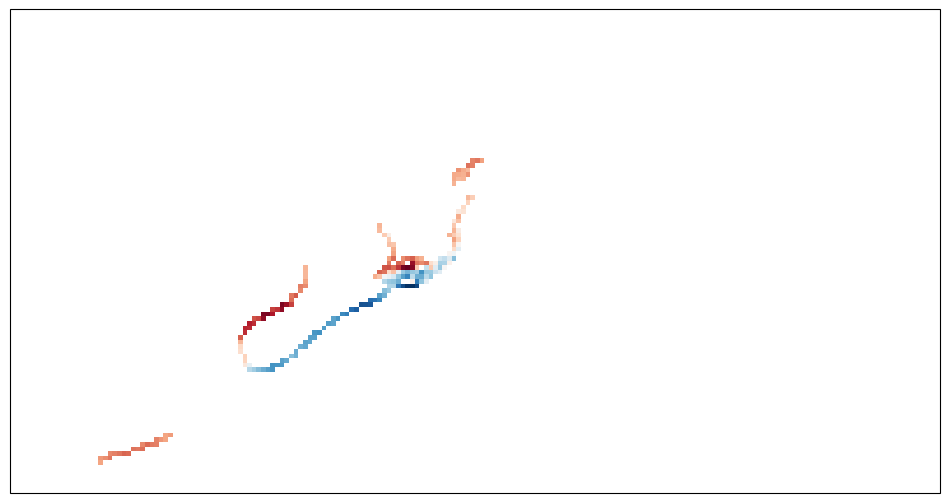

In [54]:
date_target = "2019-03-24" 

date_target_0 = datetime.datetime.strptime(date_target, "%Y-%m-%d") 
date_target_1 = date_target_0 + datetime.timedelta(days=10)
#result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_4th.nc"
result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_8th_2010_2023.nc"
map = xarray.open_dataset(result_filepath).sel(time=slice(date_target_0,date_target_1)).sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
map=map.mean(dim="time", skipna=True)

figure = pyplot.figure(figsize=(12, 12))
proj=ccrs.PlateCarree()
ax0 = pyplot.subplot(111, projection=proj)
ax0.pcolormesh(map.lon,map.lat,map.u_drifter,cmap=matplotlib.pyplot.cm.RdBu_r)

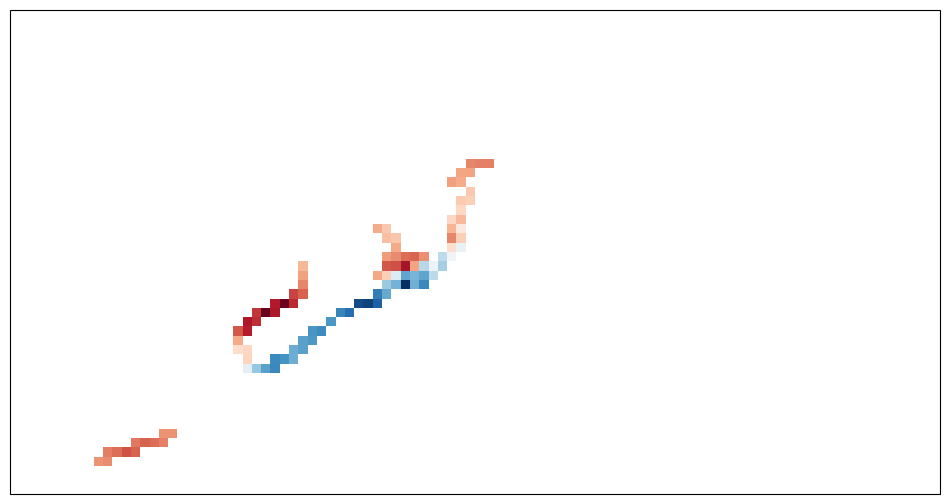

In [55]:
date_target = "2019-03-24" 

date_target_0 = datetime.datetime.strptime(date_target, "%Y-%m-%d") 
date_target_1 = date_target_0 + datetime.timedelta(days=10)
result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_4th.nc"
#result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_8th_2010_2023.nc"
map = xarray.open_dataset(result_filepath).sel(time=slice(date_target_0,date_target_1)).sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
map=map.mean(dim="time", skipna=True)

figure = pyplot.figure(figsize=(12, 12))
proj=ccrs.PlateCarree()
ax0 = pyplot.subplot(111, projection=proj)
ax0.pcolormesh(map.lon,map.lat,map.u_drifter,cmap=matplotlib.pyplot.cm.RdBu_r)


In [327]:
date_target = "2019-04-12" 
plot_lagrangian_traj(date_target)

TypeError: plot_lagrangian_traj() missing 2 required positional arguments: 'fictive_traj' and 'fictive_traj_neurost'


number of drifter : 5

number of drifter : 5


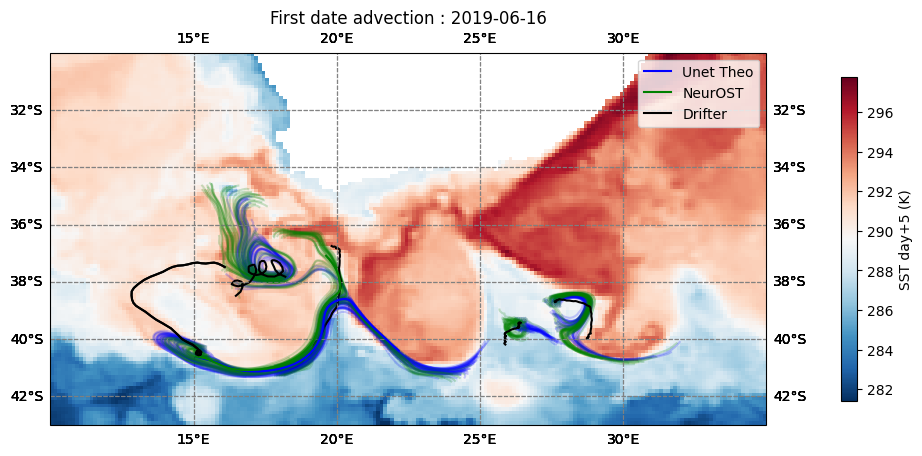

In [12]:
date_target = "2019-01-12" 
plot_lagrangian_traj(date_target)

TypeError: plot_lagrangian_traj() missing 2 required positional arguments: 'fictive_traj' and 'fictive_traj_neurost'


number of drifter : 6

number of drifter : 6


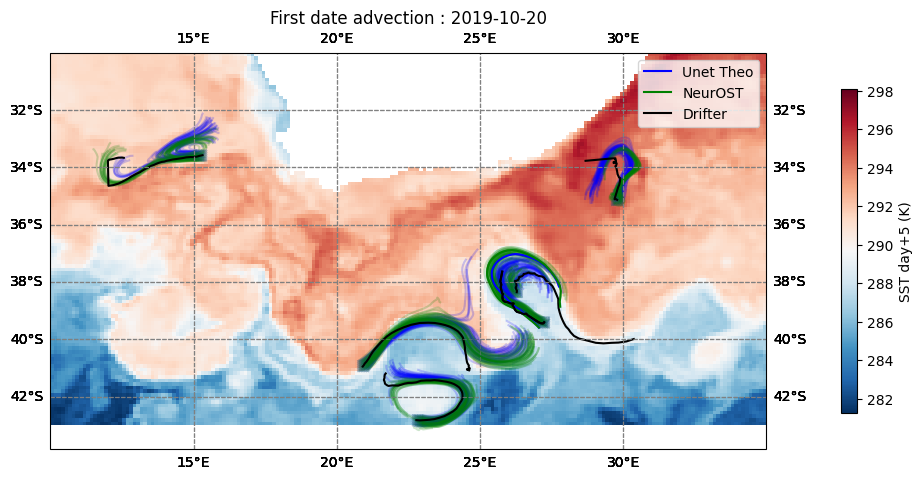

In [ ]:

plot_lagrangian_traj(date_target)


number of drifter : 7


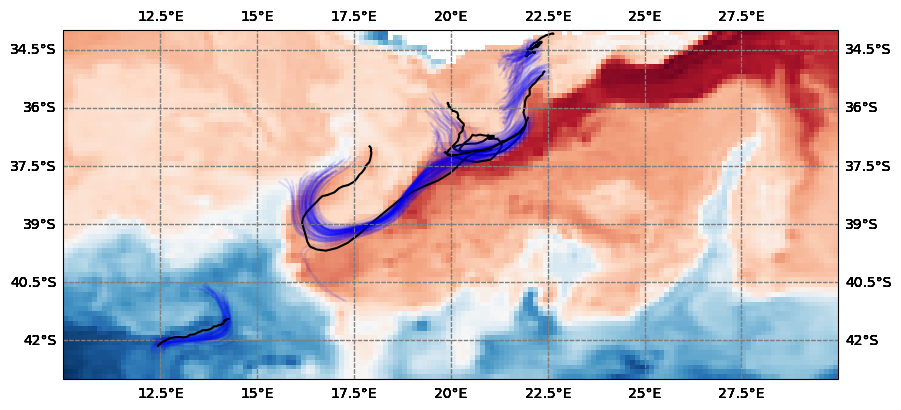

In [ ]:

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 5


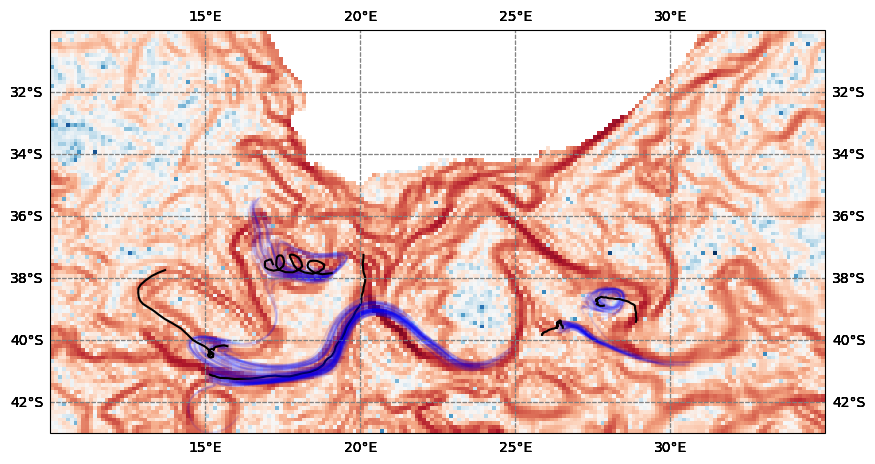

In [332]:
date_target = "2019-06-13" 
alpha=0.1

map_back = get_sst_MW(date_target)
#map_back = get_sst_L3(date_target)
map_back = get_sst_L4_8th_log(date_target)

list_advection, dic_all = get_list_advection(date_target,fictive_traj)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 5


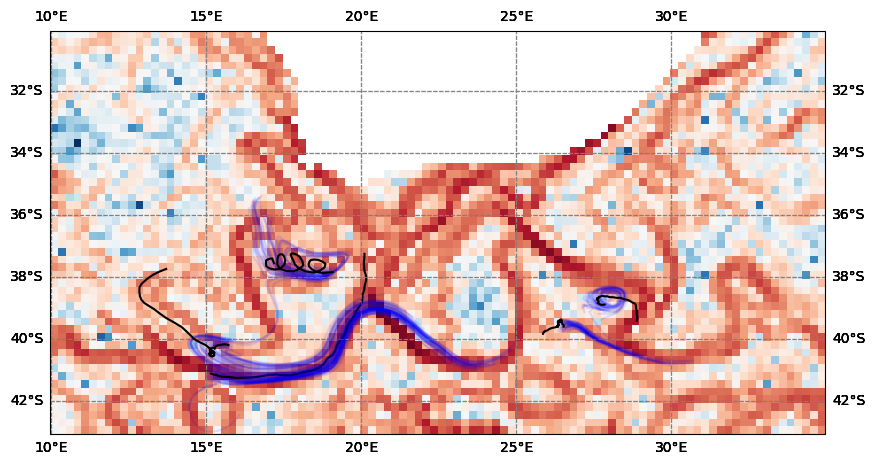

In [331]:
date_target = "2019-06-13" 
alpha=0.1

map_back = get_sst_MW(date_target)
#map_back = get_sst_L3(date_target)
map_back = get_sst_L4_4th_log(date_target)

list_advection, dic_all = get_list_advection(date_target,fictive_traj)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 6


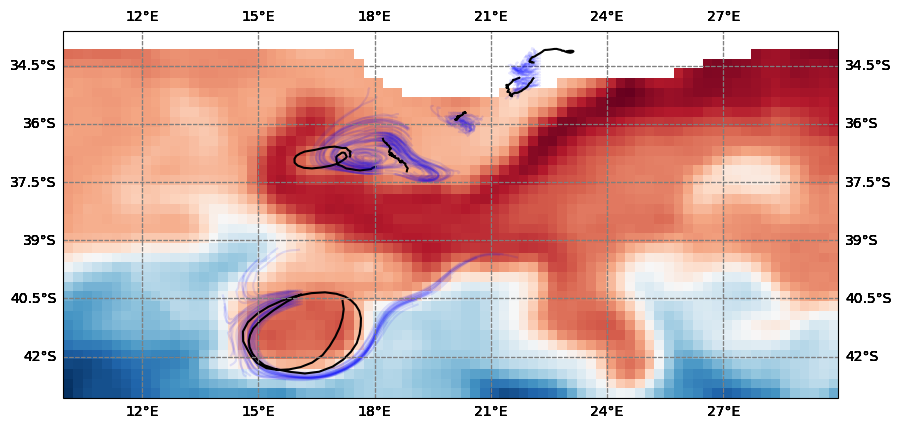

In [266]:
date_target = "2019-04-12" 
alpha=0.1

map_back = get_sst_MW(date_target)
#map_back = get_sst_L3(date_target)
#map_back = get_sst_L4_8th_log(date_target)

list_advection, dic_all = get_list_advection(date_target)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 6


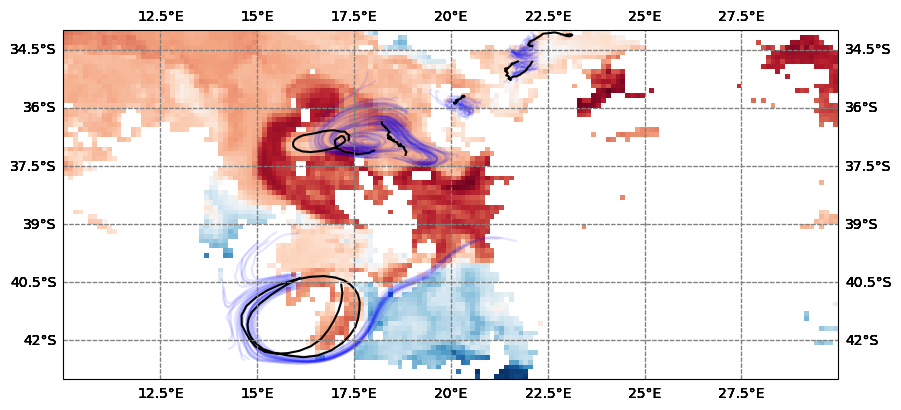

In [263]:
date_target = "2019-04-12" 
alpha=0.1

#map_back = get_sst_L3(date_target)
map_back = get_sst_L3_8th(date_target)

list_advection, dic_all = get_list_advection(date_target)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 6


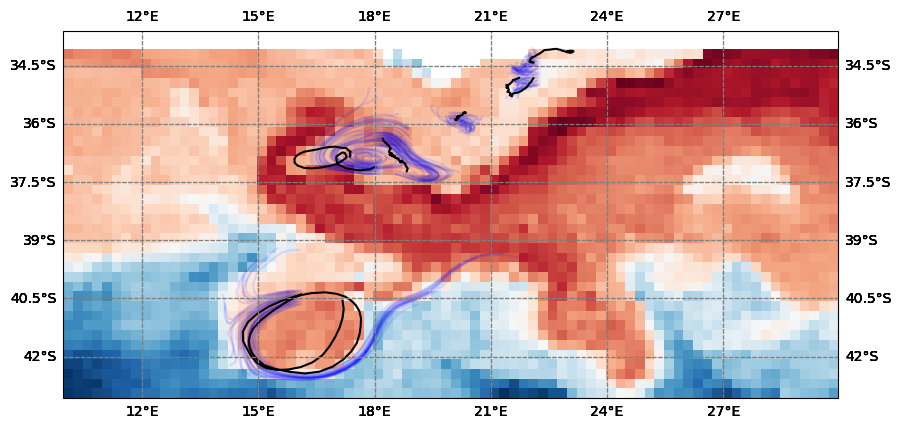

In [265]:
date_target = "2019-04-12" 
#map_back = get_sst_L3(date_target)
map_back = get_sst_L4_4th(date_target)

list_advection, dic_all = get_list_advection(date_target)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 6


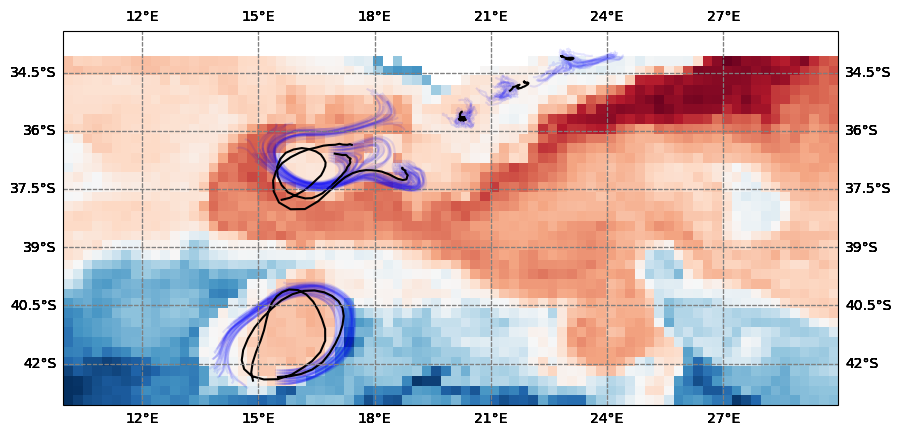

In [270]:
date_target = "2019-04-20" 
#map_back = get_sst_L3(date_target)
map_back = get_sst_L4_4th(date_target)

list_advection, dic_all = get_list_advection(date_target)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)

In [199]:
def plot_trajectory(file_out: str, lon_f: numpy.ndarray, lat_f: numpy.ndarray,
                    lon_d: numpy.ndarray, lat_d: numpy.ndarray,
                    time: numpy.ndarray, sde: numpy.ndarray,
                    proj: Optional = None, isscore: bool = True
                    ) -> pyplot.figure():

_IncompleteInputError: incomplete input (1970997830.py, line 5)

In [ ]:
def process_all_ide(input_path: str, drifter_pyo: str, dir_out: str,
                    file_out: str, isplot: Optional[bool] = True,
                    projection: Optional[str] = None,) -> dict:
    if 'gz' in os.path.splitext(drifter_pyo[0])[-1]:
        with gzip.open(drifter_pyo[0], 'rb') as f:
            dic_drif = pickle.load(f)
    else:
        with open(drifter_pyo[0], 'rb') as f:
            dic_drif = pickle.load(f)
    if os.path.isdir(input_path):
        input_netcdf = True
        list_advection = glob.glob(os.path.join(input_path, '*nc'))
    else:
        try:
            if 'gz' in os.path.splitext(input_path)[-1]:
                with gzip.open(input_path, 'rb') as f:
                    dic_all = pickle.load(f)
            else:
                with open(input_path, 'rb') as f:
                    dic_all = pickle.load(f)
        except pickle.UnpicklingError:
            logger.error(f'{input_path} should be a pickle object')
            sys.exit(1)
        input_netcdf = False
        list_advection = list(dic_all.keys())
    os.makedirs(dir_out, exist_ok=True)
    dic_result = {}
    for ifile in tqdm(list_advection[:]):
        if input_netcdf is True:
            _fname = os.path.basename(ifile)
            _fname_out = os.path.splitext(_fname)[0]
            logging.debug(f'Read Netcdf fictive trajectory {ifile}')
            hrlon, hrlat, hrtime, dic_attr = read_fictive_traj_netcdf(ifile)
        else:
            _fname_out = ifile
            res = read_fictive_traj_pickle(dic_all[ifile])
            hrlon, hrlat, hrtime, dic_attr = res
        hrlon = numpy.mod(hrlon + 180, 360) - 180
        if dic_attr['ide'] not in dic_drif:
            continue
        logging.debug(f'Read drifter data {drifter_pyo}')
        _lon = numpy.mod(numpy.array(dic_drif[dic_attr['ide']]['lon']) + 180,
                         360) - 180
        _lat = dic_drif[dic_attr['ide']]['lat']
        _time = numpy.array(dic_drif[dic_attr['ide']]['time'])
        first_day = datetime.datetime.timestamp(dic_attr['first_date'])
        # ddays = [(x - first_day).total_seconds() / 86400 for x in _time]
        ddays = [(x - first_day) / 86400 for x in _time]
        if hrtime[-1] > ddays[-1]:
            continue

        sde, dde, _lon_interp, _lat_interp = compute_nlcs(_lon, _lat, ddays,
                                                          hrlon, hrlat, hrtime)
        if numpy.all(sde[:-1] != sde[:-1]):
            continue
        res = compute_statistics(sde)
        meansde, stdsde, minsde, maxsde, mediansde, hist, nbins = res
        threshold = 4
        score = 1 - sde / threshold
        score[sde == numpy.nan] = 0
        score[score < 0] = 0
        ress = compute_statistics(score)
        meanscore, stdscore, minscore, maxscore, medianscore, hist, nbins = ress
        if meansde is None:
            continue
        file_plot_out = os.path.join(dir_out, f'{_fname_out}_sde.png')
        if isplot is True:
            _ = plot_trajectory(file_plot_out, hrlon, hrlat, _lon_interp,
                                _lat_interp, hrtime, dde*111.11, isscore=False,
                                proj=projection)
        file_plot_out = os.path.join(dir_out, f'{_fname_out}_score.png')
        if isplot is True:
            _ = plot_trajectory(file_plot_out, hrlon, hrlat, _lon_interp,
                                _lat_interp, hrtime, score, isscore=True,
                                proj=projection)

        dic_result[_fname_out] = {'time': hrtime,
                                  'meansde': meansde,
                                  'meanscore': meanscore,
                                  'stdsde':  stdsde,
                                  'stdscore': stdscore,
                                  'minsde': minsde,
                                  'minscore': minscore,
                                  'maxsde': maxsde,
                                  'maxscore': maxscore,
                                  'mediansde': mediansde,
                                  'medianscore': medianscore,
                                  'histogramsde': hist,
                                  'binsde': nbins}
        for key, value in dic_attr.items():
            dic_result[_fname_out][key] = value
    data_type = dic_attr['data_type']
    depth = dic_attr['depth']
    if depth is None:
        depth = 15
    return dic_result


In [ ]:

def plot_trajectory(file_out: str, lon_f: numpy.ndarray, lat_f: numpy.ndarray,
                    lon_d: numpy.ndarray, lat_d: numpy.ndarray,
                    time: numpy.ndarray, sde: numpy.ndarray,
                    proj: Optional = None, isscore: bool = True
                    ) -> pyplot.figure():
    
    figure = pyplot.figure(figsize=(14, 7))
    ax0 = pyplot.subplot(121, projection=proj)
    ax1 = pyplot.subplot(122)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
              numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                      alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b')
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj)
        ax1.plot(time[:-1], sde[:-1, pa])
    ax1.plot(time[:-1], numpy.nanmean(sde[:-1, :], axis=1), linewidth=3,
             color='black')
    if isscore:
        ax1.set_ylim(0.25, 1)
        ax1.set_ylabel('Score')
    else:
        ax1.set_ylim(25, 300)
        ax1.set_ylabel('cumulative separation (km)')
    ax1.set_xlabel('time from start of advection (days)')
    if proj is None:
        ax0.plot(lon_d, lat_d, '-r')
    else:
        ax0.plot(lon_d, lat_d, '-r', transform=proj)
    pyplot.savefig(file_out)
    return figure
